In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PyQt6.QtWidgets import *
from PyQt6.QtCore import *
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.measure import regionprops
from scipy.ndimage import rotate
from scipy.ndimage import binary_fill_holes
from skimage import feature
import tifffile as tiff
from pathlib import Path

In [12]:
filename = Path(
    r"Q:\11_AIRBUS\03_LabXCT\Panel Pegaso\Agujeros\19\volumen_325x1644x2321.tif"
)

data = tiff.imread(filename)

In [59]:
def get_angles(volume, reslices):
    """
    This function calculates the rotation angles for different slices of a 3D volume based on user-defined thresholds.
    It uses Otsu's method to threshold the middle slice of the volume and identifies the largest connected component.
    The orientation of this component is then used to calculate the rotation angle.

    Parameters:
    plugin (object): An instance of the plugin that is calling this function.
    volume (numpy.ndarray): A 3D numpy array representing the volume.
    reslices (dict): A dictionary indicating which slices to consider. Keys are "Main", "Left", and "Top", and values are boolean.

    Returns:
    dict: A dictionary containing the calculated rotation angles for the slices. The keys are "Main", "Left", and "Top", and the values are the calculated rotation angles in degrees.

    """

    # detect if the volume is 8bits or 16bits
    if volume.dtype == np.uint8:
        is8bit = True
    else:
        is8bit = False

    # names of the keys in the dictionary which value is True
    names = [key for key, value in reslices.items() if value == True]

    angles = {"Main": None, "Left": None, "Top": None}

    if not reslices["Main"]:
        if not reslices["Left"]:
            volume = np.transpose(volume, (2, 0, 1))
            volume = np.transpose(volume, (2, 0, 1))
        else:
            volume = np.transpose(volume, (2, 0, 1))

    if is8bit:
        top_threshold = 255
    else:
        top_threshold = 65535

    for name in names:
        while True:
            if name == "Top":
                if not reslices["Left"] and reslices["Main"]:
                    volume = np.transpose(volume, (2, 0, 1))

            top_threshold = 255

            # Check if the threshold is valid by aplying it to the middle slice
            if top_threshold != None:
                if name == "Top":
                    middle_slice = volume[len(volume) // 3].copy()
                else:
                    middle_slice = volume[len(volume) // 2].copy()

                if name == "Top":
                    # rotate the middle slice by 90 degree
                    middle_slice = np.rot90(middle_slice)

                # crop the middle slice to its half to avoid the background
                middle_slice = middle_slice[
                    middle_slice.shape[0] // 4 : middle_slice.shape[0] // 4 * 3, :
                ]

                top_index = np.where(middle_slice > top_threshold)

                middle_slice[top_index] = 0

                if is8bit:
                    threshold_value = threshold_otsu(middle_slice[middle_slice > 10])
                else:
                    threshold_value = threshold_otsu(middle_slice[middle_slice > 10000])

                print("threshold value is: ", threshold_value)

                thresholded_slice = middle_slice > threshold_value

                thresholded_slice_to_print = thresholded_slice.copy()

                # Label the objects in the thresholded slice
                labeled_slice = label(thresholded_slice)

                # Get the properties of each labeled region
                regions = regionprops(labeled_slice)

                if regions == []:
                    print("cagaste")
                    return 0

                # Find the largest connected component
                largest_component = max(regions, key=lambda region: region.area)

                # Create a mask to keep only the largest component
                mask = np.zeros_like(labeled_slice)
                mask[labeled_slice == largest_component.label] = 1
                mask = binary_fill_holes(mask).astype(int)

                # Apply the mask to the thresholded slice
                thresholded_slice = thresholded_slice * mask

                # extract edges using canny edge detector
                mask = feature.canny(mask > 0, sigma=0) > 0

                # Label the objects in the thresholded slice
                mask = label(mask)
                # print np unique of mask
                print(np.unique(mask))

                # Get the properties of each labeled region
                regions = regionprops(mask)

                # Find the second largest connected component if there is one, if not the first
                if len(regions) == 1:
                    second_largest_component = regions[0]
                else:
                    second_largest_component = sorted(
                        regions, key=lambda region: region.area
                    )[-1]

                # delete everything that is not the second largest component from mask
                mask[mask != second_largest_component.label] = 0

                try:
                    mask = get_lines2(mask)
                except:
                    print("line not smoothed")

                # Compute the rotation angle of the largest component
                rotation_angle = second_largest_component.orientation

                # Convert the angle from radians to degrees
                rotation_angle_degrees = np.degrees(rotation_angle)

                rotated_slice = rotate(thresholded_slice, -rotation_angle_degrees)

                # Print the rotation angle
                print(
                    f"The rotation angle of the largest component is {rotation_angle_degrees} degrees."
                )

                plt.figure()
                # Plotting the original middle slice
                plt.subplot(2, 2, 1)
                plt.imshow(middle_slice, cmap="gray")
                plt.title("Original Middle Slice")

                # Plotting the thresholded slice
                plt.subplot(2, 2, 2)
                plt.imshow(thresholded_slice_to_print, cmap="gray")
                plt.title("Thresholded Slice")

                # Plotting the largest component mask
                plt.subplot(2, 2, 3)
                plt.imshow(mask, cmap="gray")
                plt.title("Largest Component Mask")

                # Plotting the rotated slice
                plt.subplot(2, 2, 4)
                plt.imshow(rotated_slice, cmap="gray")
                plt.title("Rotated Slice")

                # Adjusting the layout and displaying the plot
                plt.tight_layout()
                plt.show()

                plt.show()

                # close the figure
                plt.close()

                return 0

    return angles

In [60]:
def get_lines2(image):
    """
    This function takes an image as input and draws a line from the first pixel to the last pixel of the image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    numpy.ndarray: The output image with a line drawn from the first pixel to the last pixel of the input image.
    """
    print(image.shape)

    # get the first and last pixel of the image
    linea = np.where(image >= 1)
    x0 = linea[0][0]
    x1 = linea[0][-1]
    y0 = linea[1][0]
    y1 = linea[1][-1]

    print(x0, y0, x1, y1)

    # create a image with the same size as the input image
    image2 = np.zeros_like(image)

    # draw the line on the image2
    cv2.line(image2, (y0, x0), (y1, x1), (1, 1, 1), 2)

    plt.imshow(image2)

    return image2

threshold value is:  130
[0 1 2]
(1160, 325)
1 75 1158 88
The rotation angle of the largest component is 0.5702152130340189 degrees.


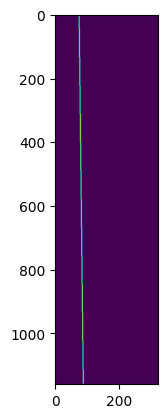

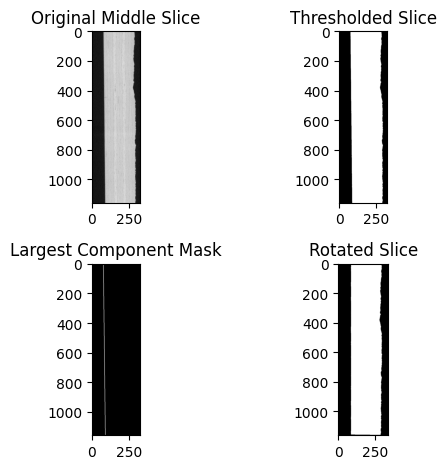

0

In [61]:
get_angles(data, {"Main": False, "Left": False, "Top": True})